In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Time-Dependent Variational Principle (TDVP)
This notebook demonstrates the capabilities of our implemented TDVP algorithm, if the underlying tensor network structure is a chain, i.e. in matrix product form. A matrix product state (MPS) is a binary tree. Therefore, we can simulate it using `PyTreeNet`. We recommend to use tensor network libraries specialised on MPS for serious simulation, due to a higher efficiency. However, utilising `PyTreeNet` on MPS is useful as an illustrative example and to test the code for mistakes, by comparing to the results yielded by the easy to implement few-site dynamics.

In [49]:
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from pytreenet.core import Node
from pytreenet.ttns import TreeTensorNetworkState
from pytreenet.ttno import TreeTensorNetworkOperator
from pytreenet.operators import pauli_matrices, TensorProduct, Hamiltonian
from pytreenet.time_evolution import (FirstOrderOneSiteTDVP,
                                      ExactTimeEvolution,
                                      SecondOrderOneSiteTDVP,
                                      TDVPConfig,
                                      TwoSiteTDVPConfig,
                                      TimeEvoMode)
from pytreenet.special_ttn import MatrixProductState

In [50]:
X, Y, Z = pauli_matrices()
time_step_size = 0.001
final_time = 1
eval_time = 10

## TDVP: A single qubit rotation on a Bloch Sphere
We use a simple Hamiltonian $H=X$ on a single qubit that is initially in the zero state $\ket{\psi} = \ket{0}$.

In [51]:
state = TreeTensorNetworkState()
tensor = np.array([1,0],dtype=complex)
single_node = Node(identifier="qubit")
state.add_root(single_node,tensor)
print(state.nodes)
print(state.tensors)

{'qubit': <pytreenet.core.node.Node object at 0x7f42cb8985d0>}
{'qubit': array([1.+0.j, 0.+0.j])}


In [52]:
ham = TreeTensorNetworkOperator()
single_ham_node = Node(identifier="qubit")
ham.add_root(single_ham_node, deepcopy(X))
print(ham.nodes)
print(ham.tensors)

{'qubit': <pytreenet.core.node.Node object at 0x7f42c422d9d0>}
{'qubit': array([[0.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j]])}


Then we set up the TDVP algorithm.

In [53]:
operators = {"Z": TensorProduct({"qubit": Z})}

In [54]:
config = TDVPConfig(time_evo_mode=TimeEvoMode.RK45)
solver_options = {
    "atol": 1e-6,
    "rtol": 1e-6
}
tdvp = FirstOrderOneSiteTDVP(state,
                             ham,time_step_size,
                             final_time,
                             operators,
                             config=config,
                             solver_options=solver_options)

print(tdvp.update_path)

['qubit']


In [55]:
np.issubdtype(np.complex128, np.complexfloating)

True

In [56]:
TimeEvoMode.CHEBYSHEV.is_scipy()

False

In [57]:
tdvp.run(evaluation_time=eval_time)
# Sanity checks
shape = tdvp.results.shape()
print(f"Num of operators: {shape[0]} (Including time)")
print(f"Num of time steps: {shape[1]} (Including initial state)")

100%|██████████| 1001/1001 [00:00<00:00, 1940.93it/s]

Num of operators: 2 (Including time)
Num of time steps: 101 (Including initial state)


Now we run an exact reference computation:

In [58]:
ref_state = np.array([1,0],dtype=complex)
ref_ham = X
operator = {"Z": Z}
exact_evo = ExactTimeEvolution(ref_state, ref_ham,
                                   time_step_size, final_time,
                                   operator)
exact_evo.run(evaluation_time=eval_time)
# Sanity checks
print("All Expecation values are real:", exact_evo.results.results_real())

100%|██████████| 1001/1001 [00:00<00:00, 423748.31it/s]

All Expecation values are real: True


In [59]:
times = tdvp.results.times()
ref_results = exact_evo.results.operator_result("Z", realise=True)
tdvp_results = tdvp.results.operator_result("Z", realise=True)
error = np.abs(ref_results - tdvp_results)

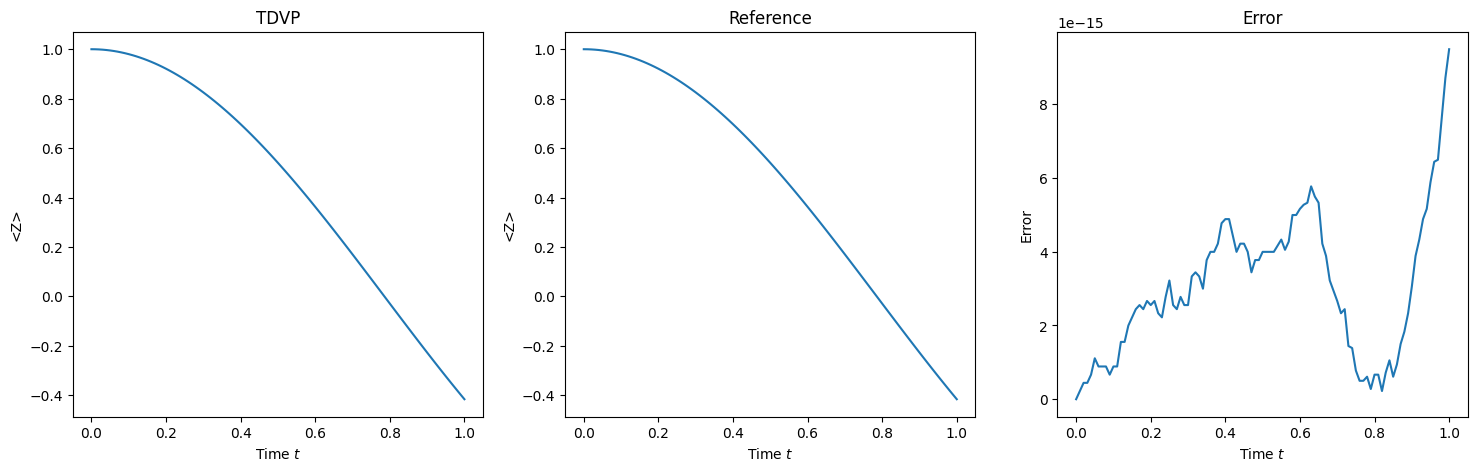

In [60]:
fig1, axs1 = plt.subplots(1,3, sharex=True, figsize=(18,5))
axs1[0].plot(times, tdvp_results)
axs1[0].set_xlabel("Time $t$")
axs1[0].set_ylabel("<Z>")
axs1[0].set_title("TDVP")

axs1[1].plot(times, ref_results)
axs1[1].set_xlabel("Time $t$")
axs1[1].set_ylabel("<Z>")
axs1[1].set_title("Reference")

axs1[2].plot(times, error)
axs1[2].set_xlabel("Time $t$")
axs1[2].set_ylabel("Error")
axs1[2].set_title("Error")

plt.show()

# TDVP with MPS: Two Qubit system evolving under Heisenberg Hamiltonian
This time we consider the Heisenberg like Hamiltonian on two qubits given by
$$
H = -J X_0X_1 -g (Z_0 + Z_1),
$$
where $X_i$ and $Z_i$ are the Pauli operators acting on qubit $i$. We start in the zero state
$$
\ket{\psi} = \ket{0}_0 \otimes \ket{0}_1.
$$

In [61]:
num_sites = 2
mJ = 1.5
mg = 0.5

In [62]:
mps_2_site = MatrixProductState.constant_product_state(0,2,num_sites,
                                                        bond_dimensions=[1])
print(list(mps_2_site.nodes.keys()))

['site0', 'site1']


In [63]:
interaction_term = TensorProduct({"site0": "mJX", "site1": "X"})
single_site_terms = [TensorProduct({"site"+str(i): "mgZ"}) for i in range(num_sites)]
terms = [interaction_term]
terms.extend(single_site_terms)
conversion_dict = {"mJX": mJ * X,
                   "X": X,
                   "mgZ": mg * Z,
                   "I2": np.eye(2)}

In [64]:
hamiltonian_2_site = Hamiltonian(terms, conversion_dict)
hamiltonian_2_site = hamiltonian_2_site.pad_with_identities(mps_2_site)
hamiltonian_2_site.terms

[(Fraction(1, 1), '1', {'site0': 'mJX', 'site1': 'X'}),
 (Fraction(1, 1), '1', {'site0': 'mgZ', 'site1': 'I2'}),
 (Fraction(1, 1), '1', {'site1': 'mgZ', 'site0': 'I2'})]

In [65]:
ham_ttno_2_site = TreeTensorNetworkOperator.from_hamiltonian(hamiltonian_2_site, mps_2_site)
operators_2_site = {"site"+str(i): TensorProduct({"site"+str(i): Z}) for i in range(num_sites)}

In [66]:
config_2_site = TDVPConfig(time_evo_mode=TimeEvoMode.RK45)
solver_options_2_site = {
    "atol": 1e-6,
    "rtol": 1e-6
}
tdvp_2_qubits = FirstOrderOneSiteTDVP(mps_2_site,
                                      ham_ttno_2_site,
                                      time_step_size,
                                      final_time,
                                      operators_2_site,
                                      config=config_2_site,
                                      solver_options=solver_options_2_site)
tdvp_2_qubits.run(evaluation_time=eval_time)

100%|██████████| 1001/1001 [00:02<00:00, 372.06it/s]


Now we run an exact reference simulation

In [67]:
ref_state = np.array([1,0,0,0],dtype=complex)
ref_ham = np.kron(conversion_dict["mJX"], conversion_dict["X"])
ref_ham += np.kron(conversion_dict["I2"], conversion_dict["mgZ"])
ref_ham += np.kron(conversion_dict["mgZ"], conversion_dict["I2"])
operator0 = np.kron(Z,np.eye(2))
operator1 = np.kron(np.eye(2),Z)
operators = {"site0": operator0, "site1": operator1}
exact_evo = ExactTimeEvolution(ref_state, ref_ham,
                                   time_step_size, final_time,
                                   operators)
exact_evo.run(evaluation_time=eval_time)

100%|██████████| 1001/1001 [00:00<00:00, 215373.87it/s]


In [68]:
times = tdvp.results.times()
ref_results_2_site_0 = exact_evo.results.operator_result("site0",realise=True)
tdvp_results_2_site_0 = tdvp_2_qubits.results.operator_result("site0",realise=True)
ref_results_2_site_1 = exact_evo.results.operator_result("site1",realise=True)
tdvp_results_2_site_1 = tdvp_2_qubits.results.operator_result("site1",realise=True)

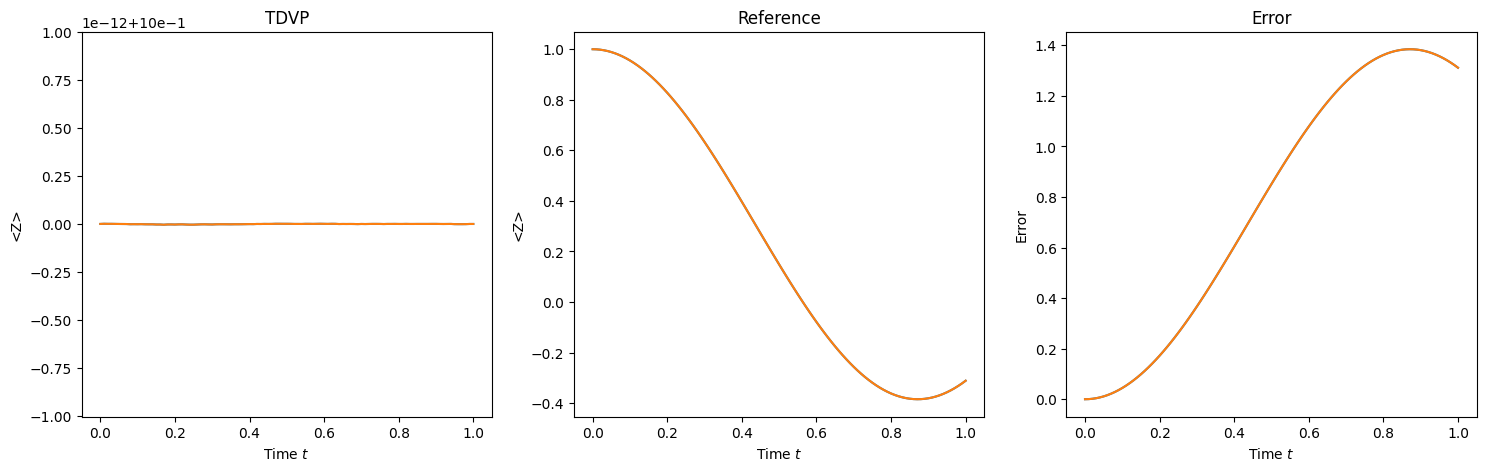

In [69]:
fig2, axs2 = plt.subplots(1,3, sharex=True, figsize=(18,5))
axs2[0].plot(times, tdvp_results_2_site_0)
axs2[0].plot(times, tdvp_results_2_site_1)
axs2[0].set_xlabel("Time $t$")
axs2[0].set_ylabel("<Z>")
axs2[0].set_title("TDVP")

axs2[1].plot(times, ref_results_2_site_0)
axs2[1].plot(times, ref_results_2_site_1)
axs2[1].set_xlabel("Time $t$")
axs2[1].set_ylabel("<Z>")
axs2[1].set_title("Reference")

axs2[2].plot(times, np.abs(ref_results_2_site_0 - tdvp_results_2_site_0))
axs2[2].plot(times, np.abs(ref_results_2_site_1 - tdvp_results_2_site_1))
axs2[2].set_xlabel("Time $t$")
axs2[2].set_ylabel("Error")
axs2[2].set_title("Error")

plt.show()

The error is large, notably because we set the bond dimension to $1$, which is smaller than required. We repeat the process with bond dimension $2$:

In [70]:
mps2 = MatrixProductState.constant_product_state(0,2,num_sites,
                                                    bond_dimensions=[2])
tdvp2_2_qubits = FirstOrderOneSiteTDVP(mps2,ham_ttno_2_site,
                                            time_step_size,final_time,
                                            operators_2_site,
                                            config=config_2_site,
                                            solver_options=solver_options_2_site)
tdvp2_2_qubits.run(evaluation_time=eval_time,pgbar=True)

100%|██████████| 1001/1001 [00:02<00:00, 447.96it/s]


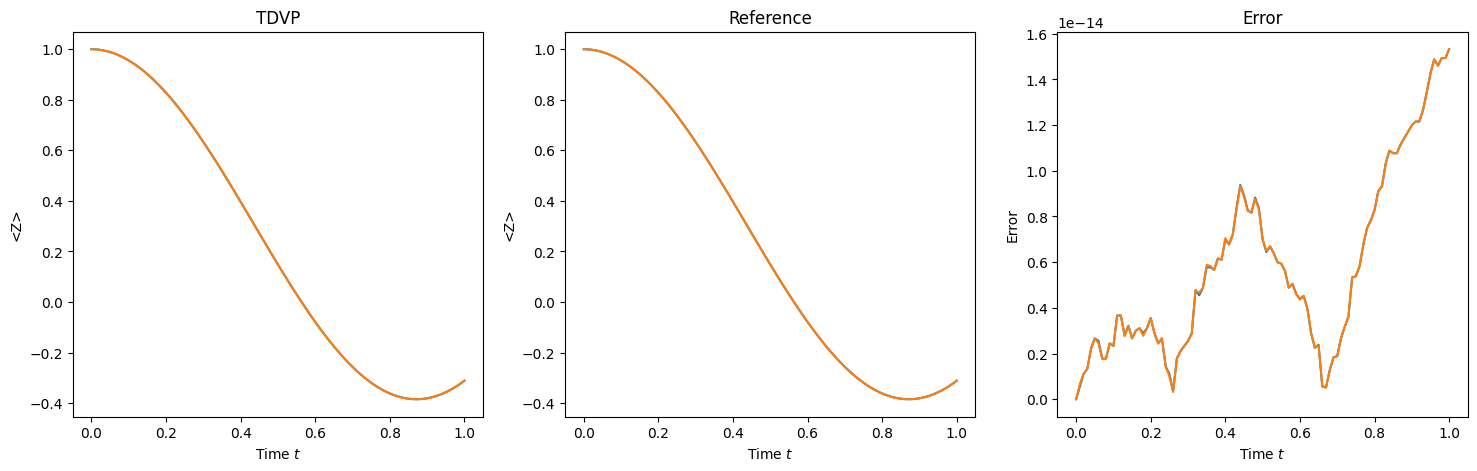

<Figure size 640x480 with 0 Axes>

In [86]:
tdvp2_results_2_site_0 = tdvp2_2_qubits.results.operator_result("site0",realise=True)
tdvp2_results_2_site_1 = tdvp2_2_qubits.results.operator_result("site1",realise=True)
fig2, axs2 = plt.subplots(1,3, sharex=True, figsize=(18,5))
axs2[0].plot(times, tdvp2_results_2_site_0)
axs2[0].plot(times, tdvp2_results_2_site_1)
axs2[0].set_xlabel("Time $t$")
axs2[0].set_ylabel("<Z>")
axs2[0].set_title("TDVP")

axs2[1].plot(times, ref_results_2_site_0)
axs2[1].plot(times, ref_results_2_site_1)
axs2[1].set_xlabel("Time $t$")
axs2[1].set_ylabel("<Z>")
axs2[1].set_title("Reference")

axs2[2].plot(times, np.abs(ref_results_2_site_0 - tdvp2_results_2_site_0))
axs2[2].plot(times, np.abs(ref_results_2_site_1 - tdvp2_results_2_site_1))
axs2[2].set_xlabel("Time $t$")
axs2[2].set_ylabel("Error")
axs2[2].set_title("Error")

plt.show()
plt.clf()

We can clearly see a significant drop in the error.

In [72]:
num_time_steps_2_qubits = list(range(10,100,10))
num_time_steps_2_qubits.extend(list(range(100,900,100)))
num_time_steps_2_qubits.extend(list(range(900,7000,100)))
num_time_steps_2_qubits.extend(list(range(7000,10000,1000)))

bond_dim = 2
mps2 = MatrixProductState.constant_product_state(0,2,num_sites,
                                                    bond_dimensions=[2])
ham_ttno = TreeTensorNetworkOperator.from_hamiltonian(hamiltonian_2_site, mps2)
results_2qubits_diff_times = []
for num_steps in tqdm(num_time_steps_2_qubits):
    tdvp = FirstOrderOneSiteTDVP(mps2,
                                 ham_ttno,
                                 time_step_size,
                                 final_time,
                                 operators_2_site,
                                 config=config_2_site,
                                 solver_options=solver_options_2_site)
    tdvp.set_num_time_steps_constant_final_time(num_steps)
    tdvp.run(evaluation_time="inf", pgbar=False)
    results_2qubits_diff_times.append(tdvp.results.operator_result("site0", realise=True))

100%|██████████| 81/81 [09:30<00:00,  7.05s/it]


In [84]:
exact_value_list_2_qubits = [ref_results_2_site_0[-1]]*len(num_time_steps_2_qubits)
error_2qubits = np.array(results_2qubits_diff_times)[:,0] - np.array(exact_value_list_2_qubits)
error_2qubits = np.abs(error_2qubits)
time_step_sizes = [final_time/num_steps for num_steps in num_time_steps_2_qubits]

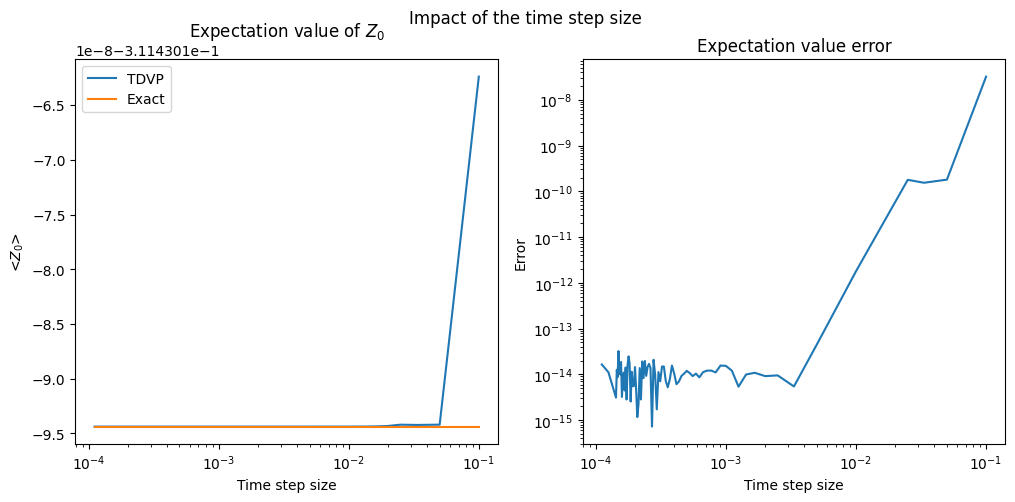

<Figure size 640x480 with 0 Axes>

In [92]:
fig_2q_num_steps, axs_2q_num_steps = plt.subplots(1,2, figsize=(12,5))

plt.suptitle("Impact of the time step size")

axs_2q_num_steps[0].semilogx(time_step_sizes, np.asarray(results_2qubits_diff_times)[:,0], label="TDVP")
axs_2q_num_steps[0].semilogx(time_step_sizes, exact_value_list_2_qubits, label="Exact")
axs_2q_num_steps[0].set_xlabel("Time step size")
axs_2q_num_steps[0].set_ylabel("<$Z_0$>")
axs_2q_num_steps[0].set_title("Expectation value of $Z_0$")
axs_2q_num_steps[0].legend()
axs_2q_num_steps[1].loglog(time_step_sizes, error_2qubits)
axs_2q_num_steps[1].set_xlabel("Time step size")
axs_2q_num_steps[1].set_ylabel("Error")
axs_2q_num_steps[1].set_title("Expectation value error")

plt.show()
plt.clf()

We find that the minimum error is around $\delta t \approx 10^{-3}$.

# TDVP with MPS: Multi-Qubit system evolving under Heisenberg Hamiltonian
This time we consider the Heisenberg like Hamiltonian on $N$-many qubits given by
$$
H = -J \sum_{i=0}^{N-2}X_i X_{i+1} -g \sum_{i=0}^{N-1} Z_i,
$$
where $X_i$ and $Z_i$ are the Pauli operators acting on qubit $i$. We start in the zero state
$$
\ket{\psi} = \bigotimes_{i=0}^{N-1} \ket{0}_i.
$$

In [75]:
num_sites = 7

In [76]:
mps = MatrixProductState.constant_product_state(0,2,num_sites,root_site=3)

In [77]:
interaction_terms = [TensorProduct({"site"+str(site): "mJX","site"+str(site+1): "X"})
                     for site in range(num_sites-1)]
single_site_terms = [TensorProduct({"site"+str(i): "mgZ"}) for i in range(num_sites)]
terms = interaction_terms
terms.extend(single_site_terms)
conversion_dict = {"mJX": mJ * X,
                   "X": X,
                   "mgZ": mg * Z,
                   "I2": np.eye(2)}

In [78]:
hamiltonian = Hamiltonian(terms, conversion_dict)
hamiltonian = hamiltonian.pad_with_identities(mps)
for term in hamiltonian.terms:
    print(term)

(Fraction(1, 1), '1', {'site0': 'mJX', 'site1': 'X', 'site3': 'I2', 'site2': 'I2', 'site4': 'I2', 'site5': 'I2', 'site6': 'I2'})
(Fraction(1, 1), '1', {'site1': 'mJX', 'site2': 'X', 'site3': 'I2', 'site0': 'I2', 'site4': 'I2', 'site5': 'I2', 'site6': 'I2'})
(Fraction(1, 1), '1', {'site2': 'mJX', 'site3': 'X', 'site1': 'I2', 'site0': 'I2', 'site4': 'I2', 'site5': 'I2', 'site6': 'I2'})
(Fraction(1, 1), '1', {'site3': 'mJX', 'site4': 'X', 'site2': 'I2', 'site1': 'I2', 'site0': 'I2', 'site5': 'I2', 'site6': 'I2'})
(Fraction(1, 1), '1', {'site4': 'mJX', 'site5': 'X', 'site3': 'I2', 'site2': 'I2', 'site1': 'I2', 'site0': 'I2', 'site6': 'I2'})
(Fraction(1, 1), '1', {'site5': 'mJX', 'site6': 'X', 'site3': 'I2', 'site2': 'I2', 'site1': 'I2', 'site0': 'I2', 'site4': 'I2'})
(Fraction(1, 1), '1', {'site0': 'mgZ', 'site3': 'I2', 'site2': 'I2', 'site1': 'I2', 'site4': 'I2', 'site5': 'I2', 'site6': 'I2'})
(Fraction(1, 1), '1', {'site1': 'mgZ', 'site3': 'I2', 'site2': 'I2', 'site0': 'I2', 'site4': 'I2

In [79]:
ham_ttno = TreeTensorNetworkOperator.from_hamiltonian(hamiltonian, mps)
operators = { "site"+str(i): TensorProduct({"site"+str(i): Z}) for i in range(num_sites)}
for operator in operators:
    print(operator)

site0
site1
site2
site3
site4
site5
site6


In [80]:
bond_dimensions = [6*[1],
                   6*[2],
                   [2,3,3,3,3,2],
                   [2,4,4,4,4,2],
                   [2,4,5,5,4,2],
                   [2,4,5,5,4,2],
                   [2,4,6,6,4,2],
                   [2,4,7,7,4,3],
                   [2,4,8,8,4,2]]

In [81]:
tdvps_multi_qubit = []
for bond_dimension in bond_dimensions:
    mps = MatrixProductState.constant_product_state(0,2,num_sites,
                                                        root_site=3,
                                                        bond_dimensions=bond_dimension)
    tdvp = FirstOrderOneSiteTDVP(mps,
                                 ham_ttno,
                                 time_step_size,
                                 final_time,
                                 operators,
                                 config=config_2_site,
                                 solver_options=solver_options_2_site)
    tdvp.run(evaluation_time=eval_time,pgbar=True)
    tdvps_multi_qubit.append(tdvp)

100%|██████████| 1001/1001 [00:12<00:00, 78.31it/s]


In [82]:
# Sanity Checks
real = True
for tdvp in tdvps_multi_qubit:
    real = real and tdvp.results.results_real()
real

True

In [93]:
times = tdvps_multi_qubit[0].results.times()
results = {"site"+str(i): [] for i in range(num_sites)}
for tdvp in tdvps_multi_qubit:
    for site in range(num_sites):
        results["site"+str(site)].append(tdvp.results.operator_result("site"+str(site), realise=True))

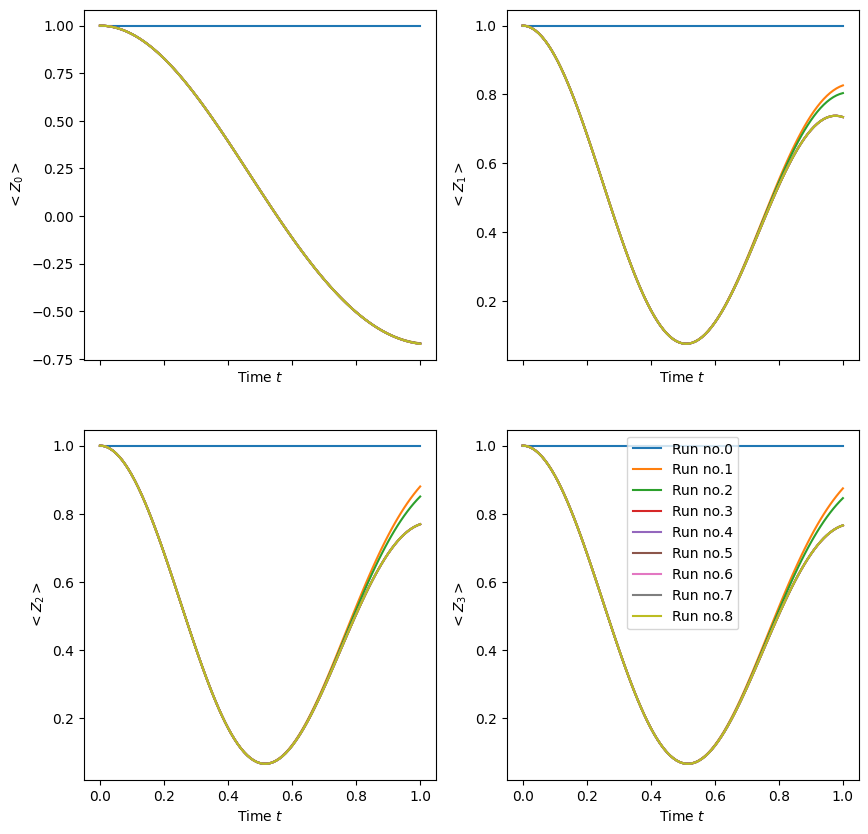

In [94]:
fig3, axs3 = plt.subplots(2,2,figsize=(10,10),sharex=True)

for i in range(len(bond_dimensions)):
    axs3[0,0].plot(times, results["site0"][i])
axs3[0,0].set_xlabel("Time $t$")
axs3[0,0].set_ylabel("$<Z_0>$")

for i in range(len(bond_dimensions)):
    axs3[0,1].plot(times, results["site1"][i])
axs3[0,1].set_xlabel("Time $t$")
axs3[0,1].set_ylabel("$<Z_1>$")

for i in range(len(bond_dimensions)):
    axs3[1,0].plot(times, results["site2"][i])
axs3[1,0].set_xlabel("Time $t$")
axs3[1,0].set_ylabel("$<Z_2>$")

for i in range(len(bond_dimensions)):
    axs3[1,1].plot(times, results["site3"][i], label="Run no." + str(i))
axs3[1,1].set_xlabel("Time $t$")
axs3[1,1].set_ylabel("$<Z_3>$")

plt.legend()
plt.show()

Let's do the reference computation.

In [95]:
print(ham_ttno.nodes.keys())
hamiltonian_matrix = ham_ttno.completely_contract_tree(to_copy=True)[0]
hamiltonian_matrix = np.transpose(hamiltonian_matrix,(6,4,2,0,8,10,12,7,5,3,1,9,11,13))
hamiltonian_matrix = np.reshape(hamiltonian_matrix,(2**num_sites,2**num_sites))
init_state = np.zeros(2**num_sites)
init_state[0] = 1
operators = num_sites*[np.asarray(1)]
for site in range(num_sites):
    for i, operator in enumerate(operators):
        if site == i:
            operators[i] = np.kron(operator, Z)
        else:
            operators[i] = np.kron(operator, np.eye(2))
operators = {"site"+str(i): operator for i, operator in enumerate(operators)}

dict_keys(['site3', 'site2', 'site1', 'site0', 'site4', 'site5', 'site6'])


In [96]:
exact_evo = ExactTimeEvolution(init_state, hamiltonian_matrix,
                                   time_step_size, final_time,
                                   operators)
exact_evo.run(evaluation_time=eval_time)

100%|██████████| 1001/1001 [00:00<00:00, 6152.97it/s]


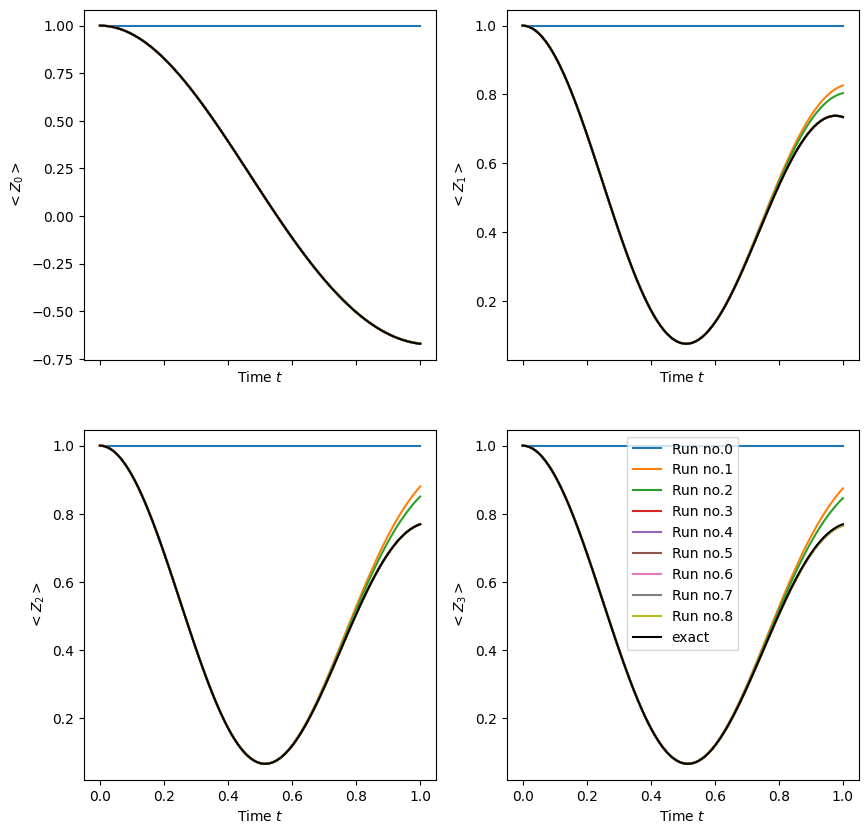

In [98]:
times = exact_evo.results.times()

fig3, axs3 = plt.subplots(2,2,figsize=(10,10),sharex=True)

for i in range(len(bond_dimensions)):
    axs3[0,0].plot(times, results["site0"][i])
axs3[0,0].plot(times, exact_evo.results.operator_result("site0", realise=True), color="black")
axs3[0,0].set_xlabel("Time $t$")
axs3[0,0].set_ylabel("$<Z_0>$")

for i in range(len(bond_dimensions)):
    axs3[0,1].plot(times, results["site1"][i])
axs3[0,1].plot(times, exact_evo.results.operator_result("site1", realise=True), color="black")
axs3[0,1].set_xlabel("Time $t$")
axs3[0,1].set_ylabel("$<Z_1>$")

for i in range(len(bond_dimensions)):
    axs3[1,0].plot(times, results["site2"][i])
axs3[1,0].plot(times, exact_evo.results.operator_result("site2", realise=True), color="black")
axs3[1,0].set_xlabel("Time $t$")
axs3[1,0].set_ylabel("$<Z_2>$")

for i in range(len(bond_dimensions)):
    axs3[1,1].plot(times, results["site3"][i], label="Run no." + str(i))
axs3[1,1].plot(times, exact_evo.results.operator_result("site2", realise=True), color="black", label="exact")
axs3[1,1].set_xlabel("Time $t$")
axs3[1,1].set_ylabel("$<Z_3>$")

plt.legend()
plt.show()

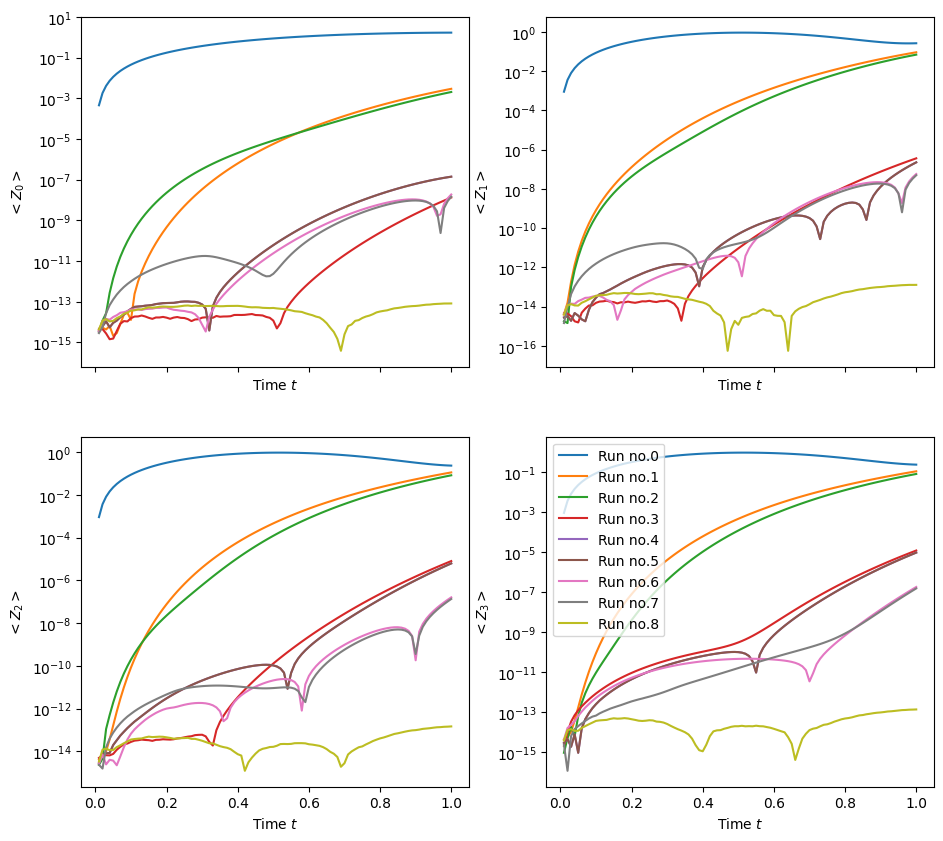

In [101]:
times = exact_evo.results.times()

fig4, axs4 = plt.subplots(2,2,figsize=(11,10),sharex=True)

for i in range(0,len(bond_dimensions)):
    axs4[0,0].semilogy(times[1:],
                       np.abs(tdvps_multi_qubit[i].results.operator_result("site0",realise=True)-exact_evo.results.operator_result("site0",realise=True))[1:])
axs4[0,0].set_xlabel("Time $t$")
axs4[0,0].set_ylabel("$<Z_0>$")

for i in range(0,len(bond_dimensions)):
    axs4[0,1].semilogy(times[1:],
                       np.abs(tdvps_multi_qubit[i].results.operator_result("site1",realise=True)-exact_evo.results.operator_result("site1",realise=True))[1:])
axs4[0,1].set_xlabel("Time $t$")
axs4[0,1].set_ylabel("$<Z_1>$")

for i in range(0,len(bond_dimensions)):
    axs4[1,0].semilogy(times[1:],
                       np.abs(tdvps_multi_qubit[i].results.operator_result("site2",realise=True)-exact_evo.results.operator_result("site2",realise=True))[1:])
axs4[1,0].set_xlabel("Time $t$")
axs4[1,0].set_ylabel("$<Z_2>$")

for i in range(0,len(bond_dimensions)):
    axs4[1,1].semilogy(times[1:],
                       np.abs(tdvps_multi_qubit[i].results.operator_result("site3",realise=True)-exact_evo.results.operator_result("site3",realise=True))[1:],
                       label="Run no." + str(i))
axs4[1,1].set_xlabel("Time $t$")
axs4[1,1].set_ylabel("$<Z_3>$")

plt.legend()
plt.show()

We can clearly see that the result improves for an increasing bond dimension. Furthermore, we find that the accuracy reduces the longer the simulation is run. Both are as one would expect.

In [102]:
num_time_steps = list(range(10,100,10))
num_time_steps.extend(list(range(100,1000,100)))
num_time_steps.extend(list(range(1000,10000,1000)))
num_time_steps.append(10000)

bond_dim = [2,4,4,4,4,2]
mps = MatrixProductState.constant_product_state(0,2,num_sites,
                                                    root_site=3,
                                                    bond_dimensions=bond_dim)
ham_ttno = TreeTensorNetworkOperator.from_hamiltonian(hamiltonian, mps)
operators = {"site"+str(i): TensorProduct({"site"+str(i): Z}) for i in range(num_sites)}
tdvps_multi_qubit_times = []
for num_steps in tqdm(num_time_steps):
    tdvp = FirstOrderOneSiteTDVP(mps,ham_ttno,
                                    time_step_size,
                                    final_time,
                                    operators,
                                    config=config_2_site,
                                    solver_options=solver_options_2_site)
    tdvp.set_num_time_steps_constant_final_time(num_steps)
    tdvp.run(evaluation_time="inf", pgbar=False)
    tdvps_multi_qubit_times.append(tdvp)


100%|██████████| 28/28 [13:59<00:00, 29.98s/it] 


In [108]:
ref_result_z0 = exact_evo.results.operator_result("site0",realise=True)[-1]
ref_result_z3 = exact_evo.results.operator_result("site3",realise=True)[-1]
expectation_values_z_0 = np.array([tdvp.results.operator_result("site0",realise=True) for tdvp in tdvps_multi_qubit_times])[:,0]
expectation_values_z_3 = np.array([tdvp.results.operator_result("site3", realise=True) for tdvp in tdvps_multi_qubit_times])[:,0]
error_z_0 = np.array([ref_result_z0 - expectation_value for expectation_value in expectation_values_z_0])
error_z_0 = np.abs(error_z_0)
error_z_3 = np.array([ref_result_z3 - expectation_value for expectation_value in expectation_values_z_3])
error_z_3 = np.abs(error_z_3)
exact_value_list_z0 = [ref_result_z0]*len(num_time_steps)
exact_value_list_z3 = [ref_result_z3]*len(num_time_steps)
time_step_sizes = [final_time/num_steps for num_steps in num_time_steps]

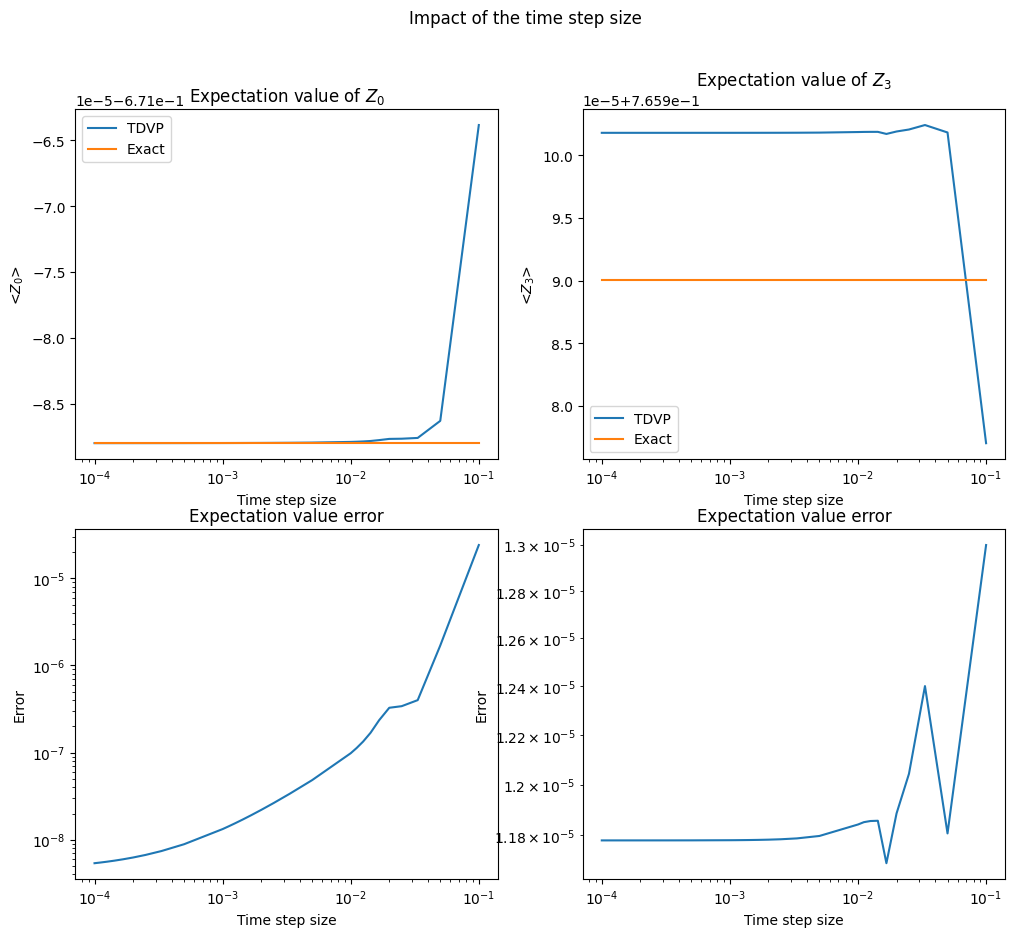

In [109]:
fig_chain_num_steps, axs_chain_num_steps = plt.subplots(2,2, figsize=(12,10))

plt.suptitle("Impact of the time step size")

axs_chain_num_steps[0,0].semilogx(time_step_sizes, expectation_values_z_0, label="TDVP")
axs_chain_num_steps[0,0].semilogx(time_step_sizes, exact_value_list_z0, label="Exact")
axs_chain_num_steps[0,0].set_xlabel("Time step size")
axs_chain_num_steps[0,0].set_ylabel("<$Z_0$>")
axs_chain_num_steps[0,0].set_title("Expectation value of $Z_0$")
axs_chain_num_steps[0,0].legend()
axs_chain_num_steps[1,0].loglog(time_step_sizes, error_z_0)
axs_chain_num_steps[1,0].set_xlabel("Time step size")
axs_chain_num_steps[1,0].set_ylabel("Error")
axs_chain_num_steps[1,0].set_title("Expectation value error")

axs_chain_num_steps[0,1].semilogx(time_step_sizes, expectation_values_z_3, label="TDVP")
axs_chain_num_steps[0,1].semilogx(time_step_sizes, exact_value_list_z3, label="Exact")
axs_chain_num_steps[0,1].set_xlabel("Time step size")
axs_chain_num_steps[0,1].set_ylabel("<$Z_3$>")
axs_chain_num_steps[0,1].set_title("Expectation value of $Z_3$")
axs_chain_num_steps[0,1].legend()
axs_chain_num_steps[1,1].loglog(time_step_sizes, error_z_3)
axs_chain_num_steps[1,1].set_xlabel("Time step size")
axs_chain_num_steps[1,1].set_ylabel("Error")
axs_chain_num_steps[1,1].set_title("Expectation value error")

plt.show()

# 2nd-order TDVP with MPS 
## Two Qubit system evolving under Heisenberg Hamiltonian
The TDVP in with a first order Trotter splitting is rather inefficient. We have to recanonicalise our TTNS after every time step. Additionally, we reduce the error in terms of the time step $\delta t$ from $O(\delta t)$ to $O(\delta t^2)$, when using a second order splitting for a comparatively low additional cost.

We will run it with the same Heisenberg model as above.

In [110]:
num_sites = 2

In [114]:
mps2 = MatrixProductState.constant_product_state(0,2,num_sites,
                                                    bond_dimensions=[2])
config_2tdvp = TwoSiteTDVPConfig(time_evo_mode=TimeEvoMode.RK45)
solver_options_2tdvp = {
    "atol": 1e-6,
    "rtol": 1e-6
}
tdvp2 = SecondOrderOneSiteTDVP(mps2,ham_ttno_2_site,
                                   time_step_size,final_time,
                                   operators_2_site,
                                   config=config_2tdvp,
                                   solver_options=solver_options_2tdvp)
tdvp2.run(evaluation_time=eval_time,pgbar=True)
# Sanity Checks
print(tdvp2.results.results_real())
print(tdvp2.results.shape())

100%|██████████| 1001/1001 [00:04<00:00, 248.81it/s]

True
(3, 101)


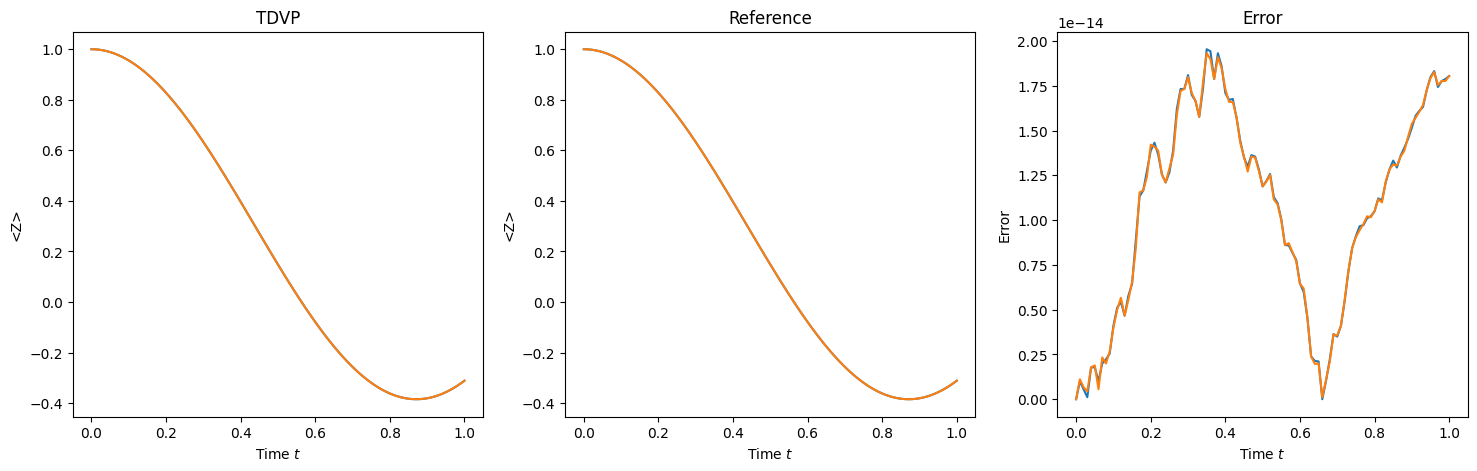

In [116]:
tdvp2_results_2_site_2nd_order_0 = tdvp2.results.operator_result("site0", realise=True)
tdvp2_results_2_site_2nd_order_1 = tdvp2.results.operator_result("site1", realise=True)
fig2, axs2 = plt.subplots(1,3, sharex=True, figsize=(18,5))
axs2[0].plot(times, tdvp2_results_2_site_2nd_order_0)
axs2[0].plot(times, tdvp2_results_2_site_2nd_order_1)
axs2[0].set_xlabel("Time $t$")
axs2[0].set_ylabel("<Z>")
axs2[0].set_title("TDVP")

axs2[1].plot(times, ref_results_2_site_0)
axs2[1].plot(times, ref_results_2_site_1)
axs2[1].set_xlabel("Time $t$")
axs2[1].set_ylabel("<Z>")
axs2[1].set_title("Reference")

axs2[2].plot(times, np.abs(ref_results_2_site_0 - tdvp2_results_2_site_2nd_order_0))
axs2[2].plot(times, np.abs(ref_results_2_site_1 - tdvp2_results_2_site_2nd_order_1))
axs2[2].set_xlabel("Time $t$")
axs2[2].set_ylabel("Error")
axs2[2].set_title("Error")

plt.show()

Let us compare the error of both orders.

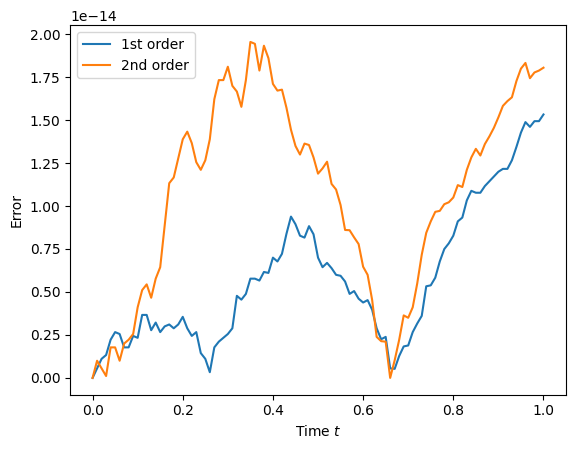

In [117]:
fig_order_comparison_2_site = plt.figure()
plt.ylabel("Error")
plt.xlabel("Time $t$")
plt.plot(times, np.abs(ref_results_2_site_0 - tdvp2_results_2_site_0),
                       label="1st order")
plt.plot(times, np.abs(ref_results_2_site_0 - tdvp2_results_2_site_2nd_order_0),
         label="2nd order")
plt.legend()
plt.show()

For these time steps we do not see a difference in performance. Most likely because both are performing well enough that the main error source is not the time step size. Let's see how the error performs with respect to differing time step sizes.

In [118]:
bond_dim = 2
mps2 = MatrixProductState.constant_product_state(0,2,num_sites,
                                                    bond_dimensions=[2])
ham_ttno = TreeTensorNetworkOperator.from_hamiltonian(hamiltonian_2_site, mps2)
results_2qubits_2ndorder_diff_times = []
for num_steps in tqdm(num_time_steps_2_qubits):
    tdvp = SecondOrderOneSiteTDVP(mps2,ham_ttno,
                                    time_step_size,final_time,
                                    operators_2_site,
                                    config=config_2tdvp,
                                    solver_options=solver_options_2tdvp)
    tdvp.set_num_time_steps_constant_final_time(num_steps)
    tdvp.run(evaluation_time="inf", pgbar=False)
    results_2qubits_2ndorder_diff_times.append(tdvp.results.operator_result("site0", realise=True))

100%|██████████| 81/81 [14:54<00:00, 11.04s/it]


In [120]:
error_2qubits_2ndorder = np.array(results_2qubits_2ndorder_diff_times)[:,0] - np.array(exact_value_list_2_qubits)
error_2qubits_2ndorder = np.abs(error_2qubits_2ndorder)
time_step_sizes = [final_time/num_steps for num_steps in num_time_steps_2_qubits]

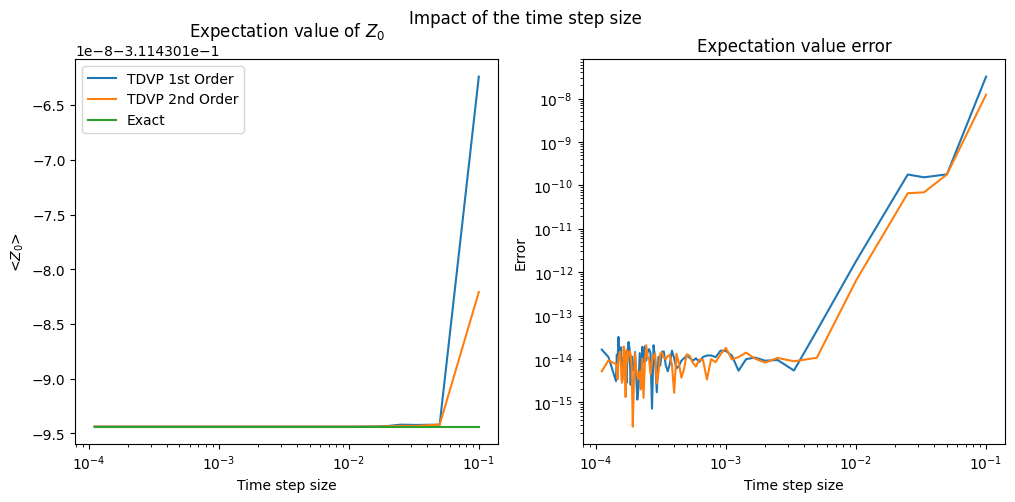

In [122]:
fig_2q_num_steps, axs_2q_num_steps = plt.subplots(1,2, figsize=(12,5))

plt.suptitle("Impact of the time step size")

axs_2q_num_steps[0].semilogx(time_step_sizes, np.asarray(results_2qubits_diff_times)[:,0], label="TDVP 1st Order")
axs_2q_num_steps[0].semilogx(time_step_sizes, np.asarray(results_2qubits_2ndorder_diff_times)[:,0], label="TDVP 2nd Order")
axs_2q_num_steps[0].semilogx(time_step_sizes, exact_value_list_2_qubits, label="Exact")
axs_2q_num_steps[0].set_xlabel("Time step size")
axs_2q_num_steps[0].set_ylabel("<$Z_0$>")
axs_2q_num_steps[0].set_title("Expectation value of $Z_0$")
axs_2q_num_steps[0].legend()
axs_2q_num_steps[1].loglog(time_step_sizes, error_2qubits)
axs_2q_num_steps[1].loglog(time_step_sizes, error_2qubits_2ndorder)
axs_2q_num_steps[1].set_xlabel("Time step size")
axs_2q_num_steps[1].set_ylabel("Error")
axs_2q_num_steps[1].set_title("Expectation value error")

plt.show()

## Multi-Qubit system evolving under Heisenberg Hamiltonian
We will run it with the same Heisenberg model as above.

In [123]:
num_sites = 7
mps = MatrixProductState.constant_product_state(0,2,num_sites,root_site=3)

In [124]:
interaction_terms = [TensorProduct({"site"+str(site): "mJX","site"+str(site+1): "X"})
                     for site in range(num_sites-1)]
single_site_terms = [TensorProduct({"site"+str(i): "mgZ"}) for i in range(num_sites)]
terms = interaction_terms
terms.extend(single_site_terms)
conversion_dict = {"mJX": mJ * X,
                   "X": X,
                   "mgZ": mg * Z,
                   "I2": np.eye(2)}

In [125]:
hamiltonian = Hamiltonian(terms, conversion_dict)
hamiltonian = hamiltonian.pad_with_identities(mps)
ham_ttno = TreeTensorNetworkOperator.from_hamiltonian(hamiltonian, mps)
operators = {"site"+str(i): TensorProduct({"site"+str(i): Z}) for i in range(num_sites)}

In [126]:
bond_dimensions = [6*[1],
                   6*[2],
                   [2,3,3,3,3,2],
                   [2,4,4,4,4,2],
                   [2,4,5,5,4,2],
                   [2,4,5,5,4,2],
                   [2,4,6,6,4,2],
                   [2,4,7,7,4,3],
                   [2,4,8,8,4,2]]

In [127]:
config_multi_qubit_2nd_order = TwoSiteTDVPConfig(time_evo_mode=TimeEvoMode.RK45)
solver_options_multi_qubit_2nd_order = {
    "atol": 1e-6,
    "rtol": 1e-6
}
tdvps_2nd_order = []
for bond_dimension in bond_dimensions:
    mps = MatrixProductState.constant_product_state(0,2,num_sites,
                                                        root_site=3,
                                                        bond_dimensions=bond_dimension)
    tdvp = SecondOrderOneSiteTDVP(mps,ham_ttno,
                                      time_step_size,final_time,
                                      operators,
                                      config=config_multi_qubit_2nd_order,
                                      solver_options=solver_options_multi_qubit_2nd_order)
    tdvp.run(evaluation_time=eval_time,pgbar=True)
    tdvps_2nd_order.append(tdvp)

100%|██████████| 1001/1001 [00:21<00:00, 47.09it/s]


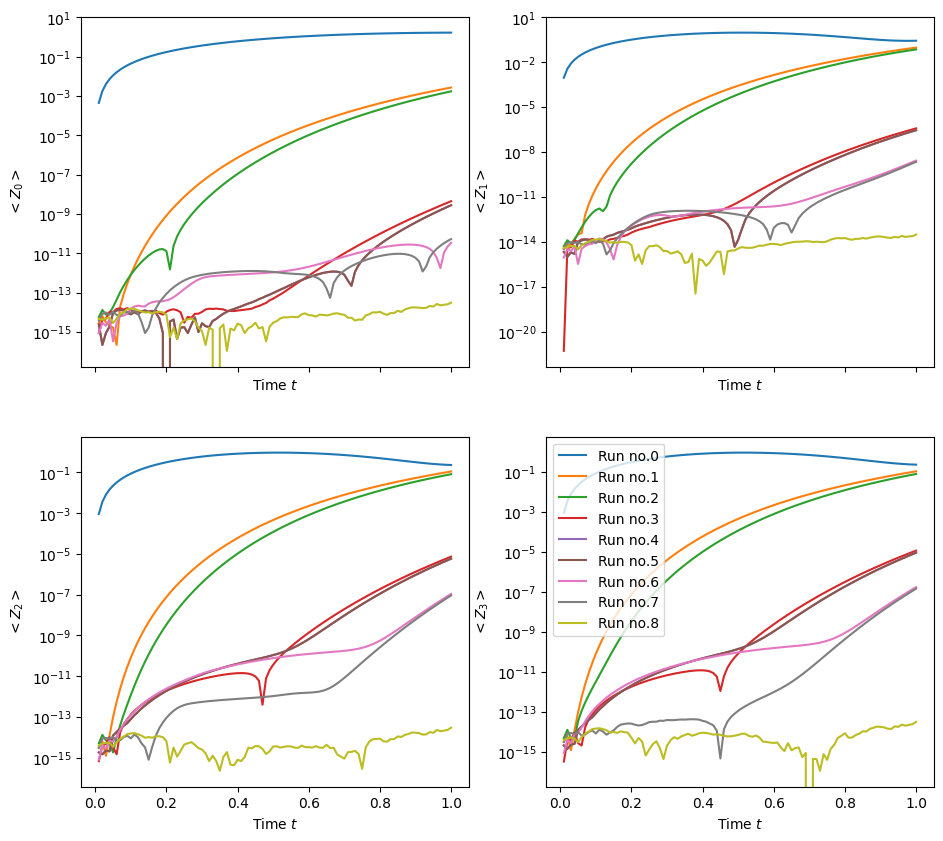

In [129]:
times = tdvps_2nd_order[0].results.times()
fig5, axs5 = plt.subplots(2,2,figsize=(11,10),sharex=True)

for i in range(0,len(bond_dimensions)):
    axs5[0,0].semilogy(times[1:],
                       np.abs(tdvps_2nd_order[i].results.operator_result("site0")-exact_evo.results.operator_result("site0"))[1:])
axs5[0,0].set_xlabel("Time $t$")
axs5[0,0].set_ylabel("$<Z_0>$")

for i in range(0,len(bond_dimensions)):
    axs5[0,1].semilogy(times[1:],
                       np.abs(tdvps_2nd_order[i].results.operator_result("site1")-exact_evo.results.operator_result("site1"))[1:])
axs5[0,1].set_xlabel("Time $t$")
axs5[0,1].set_ylabel("$<Z_1>$")

for i in range(0,len(bond_dimensions)):
    axs5[1,0].semilogy(times[1:],
                       np.abs(tdvps_2nd_order[i].results.operator_result("site2")-exact_evo.results.operator_result("site2"))[1:])
axs5[1,0].set_xlabel("Time $t$")
axs5[1,0].set_ylabel("$<Z_2>$")

for i in range(0,len(bond_dimensions)):
    axs5[1,1].semilogy(times[1:],
                       np.abs(tdvps_2nd_order[i].results.operator_result("site3")-exact_evo.results.operator_result("site3"))[1:],
                       label="Run no." + str(i))
axs5[1,1].set_xlabel("Time $t$")
axs5[1,1].set_ylabel("$<Z_3>$")

plt.legend()
plt.show()

We can compare the two different orders with respect to their errors. To reduce clutter we will only show runs 2, 5, 7, and 8 for $Z_3$, which tends to have the highest error.

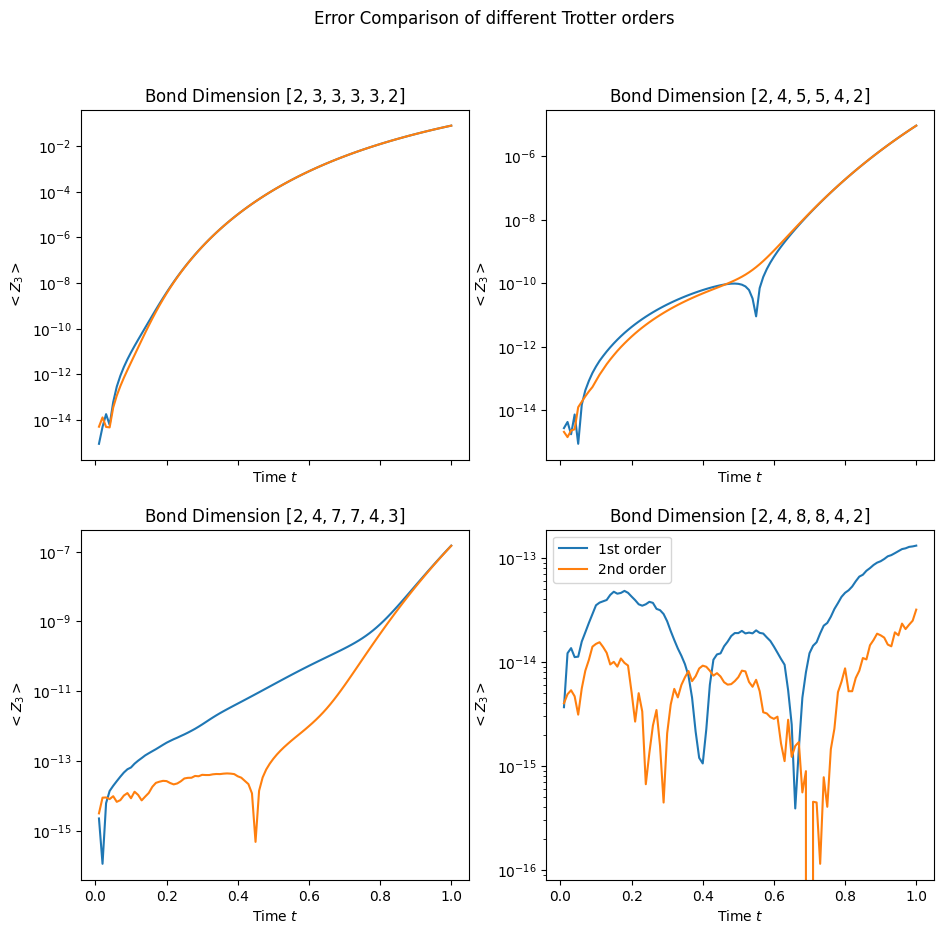

In [130]:
times = tdvps_2nd_order[0].results.times()
fig6, axs6 = plt.subplots(2,2,figsize=(11,10),sharex=True)

plt.suptitle("Error Comparison of different Trotter orders")

axs6[0,0].set_title("Bond Dimension $[2,3,3,3,3,2]$")
axs6[0,0].semilogy(times[1:],
                   np.abs(tdvps_multi_qubit[2].results.operator_result("site3") - exact_evo.results.operator_result("site3"))[1:],
                   label="1st order")
axs6[0,0].semilogy(times[1:],
                   np.abs(tdvps_2nd_order[2].results.operator_result("site3") - exact_evo.results.operator_result("site3"))[1:],
                   label="2nd order")
axs6[0,0].set_xlabel("Time $t$")
axs6[0,0].set_ylabel("$<Z_3>$")

axs6[0,1].set_title("Bond Dimension $[2,4,5,5,4,2]$")
axs6[0,1].semilogy(times[1:],
                   np.abs(tdvps_multi_qubit[5].results.operator_result("site3") - exact_evo.results.operator_result("site3"))[1:],
                   label="1st order")
axs6[0,1].semilogy(times[1:],
                   np.abs(tdvps_2nd_order[5].results.operator_result("site3") - exact_evo.results.operator_result("site3"))[1:],
                   label="2nd order")
axs6[0,1].set_xlabel("Time $t$")
axs6[0,1].set_ylabel("$<Z_3>$")

axs6[1,0].set_title("Bond Dimension $[2,4,7,7,4,3]$")
axs6[1,0].semilogy(times[1:],
                   np.abs(tdvps_multi_qubit[7].results.operator_result("site3") - exact_evo.results.operator_result("site3"))[1:],
                   label="1st order")
axs6[1,0].semilogy(times[1:],
                   np.abs(tdvps_2nd_order[7].results.operator_result("site3") - exact_evo.results.operator_result("site3"))[1:],
                   label="2nd order")
axs6[1,0].set_xlabel("Time $t$")
axs6[1,0].set_ylabel("$<Z_3>$")

axs6[1,1].set_title("Bond Dimension $[2,4,8,8,4,2]$")
axs6[1,1].semilogy(times[1:],
                   np.abs(tdvps_multi_qubit[8].results.operator_result("site3") - exact_evo.results.operator_result("site3"))[1:],
                   label="1st order")
axs6[1,1].semilogy(times[1:],
                   np.abs(tdvps_2nd_order[8].results.operator_result("site3") - exact_evo.results.operator_result("site3"))[1:],
                   label="2nd order")
axs6[1,1].set_xlabel("Time $t$")
axs6[1,1].set_ylabel("$<Z_3>$")

plt.legend()
plt.show()

We can see that the 2nd order Trotterisation has a lower error, as long as the time is the major contribution to the error, rather than the insufficient bond dimension.